### Business Overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
**For many incumbent operators, retaining high profitable customers is the number one business goal.**

**To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.**

### Objective

In this project, we will 
* analyze customer-level data of a leading telecom firm, 
* build predictive models to identify customers at high risk of churn and 
* identify the main indicators of churn.

#### Churn Definition

This project is based on Indian and Southeast Asian market and fillowing **Usage-based Churn definition** will be used:

*Usage-based churn:Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.*

#### High Value Churn

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

#### Data and Business Objective

**dataset**: The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

**business objective**: is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

####  Understanding Customer Behaviour during Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1. The **‘good’ phase**: In this phase, the customer is happy with the service and behaves as usual.

2. The **‘action’ phase**: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. The **‘churn’ phase**: In this phase, the customer is said to have churned. We define churn based on this phase.

In this project, since we are working over a four-month window:
* the first two months (6th and 7th month data) are the ‘good’ phase, 
* the third month (8th month) is the ‘action’ phase, 
* while the fourth month (9th month) is the ‘churn’ phase.

### Approach and final solution

The following approach was followed for churn modeling:

1. Data load, cleaning and Exploratory Data Analysis was done.
2. From above steps useful patterns were identified, in particular a significant drop in many features was observed during action phase.
3. Handling of NA values and outliers was done on a feature by feature basis.
4. Relationships among different features were also identified during EDA phase, and feature for which there were component features present in the data set were dropped.
3. Feature engineering was done, in particular the following broad steps were taken:
   * New features were created for good phase by taking the average of 6th and 7th month values.
   * New features were derived from date related values.
   * New features were derived in action phase by taking the difference between good phase and 8th month corresponding features.
4. Feature standardization was done.
5. As the data set is highly imbalanced towards the 'Non-churn' majority class, imbalanced data set handling was done, specifically the following two techniques were followed.
    * SMOTE: synthetic sample generation for minority class.
    * Majority class under sampling.
6. From above majority class under sampling gave better results and hence was used for final model building. Data was divided into training and test set.
7. Basic model was created using Logistic Regression.
8. As churn prediction is primary motive **sensitivity and f1 score** were looked into to be maximized.
9. Feature reduction was done using PCA (the reduced feature set contained ~ 35 feature).
10. Baseline model was created.
11. Multiple boosting models were tried namely - Ada Boost,Gradient Boosting and XgBoost.
12. An ensemble model using majority vote strategy was also created using Logistic Regression, Decision trees, Random Forest and Linear SVM.
13. The best prediction model was obtained using XgBoost were a **sensitivity of approx. 90% a precision of 33% and f1 score of 48% was obtained**.
14. For understanding factors for churn a logistic regression model was build and features influencing churn were obtained using LASSO and feature elimination using high p-value and VIF for multicollinearity.
15. Finally recommendation and strategies were suggested for reducing churn.

### Import all the required Libraries

In [269]:
# import numpy and pandas
import pandas as pd
import numpy as np

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# do an inline so that plt.show() is not required everytime
%matplotlib inline

# import for pre-processing
# scale (this is same as standard scalar)
from sklearn.preprocessing import scale
# label encoding
from sklearn.preprocessing import LabelEncoder

# import for model selection:
# splitting data into training and test data (validation set)
from sklearn.model_selection import train_test_split
# import for creating K-folds
from sklearn.model_selection import KFold
# import for CV using folds created
from sklearn.model_selection import cross_val_score
# import for grid search cv for Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# for deleting unused variables
import gc

# filter warnings
import os
import warnings
warnings.filterwarnings('ignore')

### Generic Function (Used multiple times)

In [270]:
def get_nulls_report(df,apply_style="Y"):
    if apply_style=="Y":
        cm = sns.light_palette("orange", as_cmap=True)
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False).style.background_gradient(cmap=cm)
    else:
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False)

### Load Data and Data Cleaning

In [271]:
# Fetch the Telecom Churn Data
telecom_data = pd.read_csv('./telecom_churn_data.csv')

In [272]:
# Inspect the data from the dataframe
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [273]:
# Checking the Shape of the Dataframe
telecom_data.shape

(99999, 226)

**INFO** - The Dataframe Contains below details
      - No Of Records - 99999
      - No Of Columne - 226 (This is a big number , we definetly needs feature reduction)

In [274]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [275]:
# Fetching the Null Reports of the Dataset
get_nulls_report(telecom_data)

,Total Nulls,Nulls Percentage
arpu_3g_6,74846,74.85
night_pck_user_6,74846,74.85
total_rech_data_6,74846,74.85
arpu_2g_6,74846,74.85
max_rech_data_6,74846,74.85
fb_user_6,74846,74.85
av_rech_amt_data_6,74846,74.85
date_of_last_rech_data_6,74846,74.85
count_rech_2g_6,74846,74.85
count_rech_3g_6,74846,74.85


**INFO** - It looks like lots of the data contains Nulls Value
     - We need to clean or Impute such records/Columns

##### For many incumbent operators, retaining high profitable customers is the number one business goal.We will do the same in our Analysis.

#### Data Analysis on the Recharge the customer made

In [276]:
recharge_amnt_columns = [col for col in telecom_data.columns if 'rech_amt' in col or  'rech_data' in col]

In [277]:
recharge_amnt_columns

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9']

INFO - We have 3 categories of columns which will be used to indetify the top customers

- **CATEGORY 1** -> total recharge amount,
- **CATEGORY 2** -> maximum recharge amount and 
- **CATEGORY 3** -> average recharge amount for data.
- **CATEGORY 4** -> total recharge for data
- **CATEGORY 5** -> maximum recharge for data

In [278]:
# let us check if there are any missing values for recharge amount
get_nulls_report(telecom_data[recharge_amnt_columns])

,Total Nulls,Nulls Percentage
total_rech_data_6,74846,74.85
av_rech_amt_data_6,74846,74.85
max_rech_data_6,74846,74.85
date_of_last_rech_data_6,74846,74.85
av_rech_amt_data_7,74428,74.43
max_rech_data_7,74428,74.43
date_of_last_rech_data_7,74428,74.43
total_rech_data_7,74428,74.43
date_of_last_rech_data_9,74077,74.08
max_rech_data_9,74077,74.08


INFO - 
  - Obsrervation is **74-75%** of data is missing or null in all the 5 category mentioned above

In [279]:
recharge_amnt_columns_6 = telecom_data.columns[telecom_data.columns.str.contains('rech_amt_6|rech_data_6|rech_amt_data_6')]

telecom_data.loc[:,recharge_amnt_columns_6].describe()

,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,av_rech_amt_data_6
count,99999.000000,99999.000000,25153.000000,25153.000000,25153.000000
mean,327.514615,104.637486,2.463802,126.393392,192.600982
std,398.019701,120.614894,2.789128,108.477235,192.646318
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,109.000000,30.000000,1.000000,25.000000,82.000000
50%,230.000000,110.000000,1.000000,145.000000,154.000000
75%,437.500000,120.000000,3.000000,177.000000,252.000000
max,35190.000000,4010.000000,61.000000,1555.000000,7546.000000


We can see that total_rech_data has discrete values and the non NA values for total_rech_data and av_rech_amt_data is the same, thus we can find out the total recharge amount for data from the two.

In [280]:
# Checking the total_rech_data is NA/null and value is present for av_rech_amt_data and vice versa
# check how many av_rech_amt_data_6 is NA
null_data_6 = telecom_data['total_rech_data_6'].isnull()
null_data_7 = telecom_data['total_rech_data_7'].isnull()
null_data_8 = telecom_data['total_rech_data_8'].isnull()

# check if any value is present for these rows for total_rech_data_x
print("Total Recharge Data 6 Nulls are -",telecom_data.loc[null_data_6,'total_rech_data_6'].sum())
print("Total Recharge Data 7 Nulls are -",telecom_data.loc[null_data_7,'total_rech_data_7'].sum())
print("Total Recharge Data 8 Nulls are -",telecom_data.loc[null_data_8,'total_rech_data_8'].sum())

# check if any value is present for these rows for av_rech_amt_data_x
print("Avg Recharge amt 6 Nulls are -",telecom_data.loc[null_data_6,'av_rech_amt_data_6'].sum())
print("Avg Recharge amt 7 Nulls are -",telecom_data.loc[null_data_7,'av_rech_amt_data_7'].sum())
print("Avg Recharge amt 8 Nulls are -",telecom_data.loc[null_data_8,'av_rech_amt_data_8'].sum())

Total Recharge Data 6 Nulls are - 0.0
Total Recharge Data 7 Nulls are - 0.0
Total Recharge Data 8 Nulls are - 0.0
Avg Recharge amt 6 Nulls are - 0.0
Avg Recharge amt 7 Nulls are - 0.0
Avg Recharge amt 8 Nulls are - 0.0


INFO - The observation is ,if the total_rech_data is null , then the avg_rech_amt is also null
     - The above is true for Vice Versa
     - We are good to impute 0 for all the above records , as this means no recharge

In [281]:
telecom_data[['total_rech_data_6','total_rech_data_7','total_rech_data_8']]=telecom_data[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].fillna(0)
telecom_data[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']]=telecom_data[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']].fillna(0)

In [282]:
# New derived variable total recharge amount for data: av_rech_amt_data_x*total_rech_data_x
telecom_data['total_rech_amt_data_6'] = telecom_data.av_rech_amt_data_6*telecom_data.total_rech_data_6
telecom_data['total_rech_amt_data_7'] = telecom_data.av_rech_amt_data_7*telecom_data.total_rech_data_7
telecom_data['total_rech_amt_data_8'] = telecom_data.av_rech_amt_data_8*telecom_data.total_rech_data_8

##### New Derived Variable 
- total_avg_rech_amnt_good_ph : We will define total average recharge amount for good phase as the average of total recharge amount and total recharge amount for data for months 6 and 7 (good phase months).

In [283]:
telecom_data['total_avg_rech_amnt_good_ph'] = (telecom_data.total_rech_amt_6 +telecom_data.total_rech_amt_data_6 \
                                               + telecom_data.total_rech_amt_7+telecom_data.total_rech_amt_data_7)/4

#### Criteria to Filter High Value Customers####
- Those people who have total average recharge amount for good phase greater than the 70th percentile value.

In [284]:
high_value_filter = telecom_data.total_avg_rech_amnt_good_ph >= telecom_data.total_avg_rech_amnt_good_ph.quantile(0.7)

In [285]:
# Update the Dataframe with only High Value Customers
telecom_data = telecom_data.loc[high_value_filter,:]

In [286]:
# Total High Value Customers after filtering the data are
len(telecom_data.index)

30001

#### creating labels for churned customers.

In [287]:
# Now let us label the churned customers
# define a new column in data frame as 'churn' with value as 1 if customer has churned and 0 if customer has not churned
# Initially set all the values as 0
telecom_data['churn']= 0

In [288]:
# the following columns will be used to find the churned customers in the 9th month 
# total_ic_mou_9, total_ic_mou_9, vol_2g_mb_9 and vol_3g_mb_9
# let's check if any NA/Null values are present
ls_9 = ['total_ic_mou_9', 'total_ic_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']
100*telecom_data.loc[:,ls_9].isnull().sum()/len(telecom_data)

total_ic_mou_9    0.0
total_ic_mou_9    0.0
vol_2g_mb_9       0.0
vol_3g_mb_9       0.0
dtype: float64

In [289]:
# define is_churned boolean flag for customers where above values are zero
is_churned = (telecom_data.total_ic_mou_9 == 0) & (telecom_data.total_ic_mou_9 == 0) & (telecom_data.vol_2g_mb_9 ==0)& \
(telecom_data.vol_3g_mb_9 ==0)

In [290]:
# set all such rows fulfilling is_churned condition as 1
telecom_data.loc[is_churned,'churn']=1

In [291]:
# let us check what's the % of churned customers
100*telecom_data.churn.sum()/len(is_churned)

8.406386453784874

INFO 
 - We see that approx. 8.4% of high value customers have churned

In [292]:
# let's extract all list of 9th Month (churned month) Columns
month_9_columns =  telecom_data.columns[telecom_data.columns.str.contains('_9')]

In [293]:
# drop all columns corresponding to the attributes of churn phase
telecom_data.drop(month_9_columns,axis=1,inplace=True)

In [294]:
# let's check how many columns remain
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 177 entries, mobile_number to churn
dtypes: float64(140), int64(28), object(9)
memory usage: 40.7+ MB


In [295]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 177 entries, mobile_number to churn
dtypes: float64(140), int64(28), object(9)
memory usage: 40.7+ MB


In [296]:
100*telecom_data.isnull().sum()/len(telecom_data.index)

mobile_number                   0.000000
circle_id                       0.000000
loc_og_t2o_mou                  0.746642
std_og_t2o_mou                  0.746642
loc_ic_t2o_mou                  0.746642
last_date_of_month_6            0.000000
last_date_of_month_7            0.089997
last_date_of_month_8            0.549982
arpu_6                          0.000000
arpu_7                          0.000000
arpu_8                          0.000000
onnet_mou_6                     1.816606
onnet_mou_7                     1.789940
onnet_mou_8                     3.913203
offnet_mou_6                    1.816606
offnet_mou_7                    1.789940
offnet_mou_8                    3.913203
roam_ic_mou_6                   1.816606
roam_ic_mou_7                   1.789940
roam_ic_mou_8                   3.913203
roam_og_mou_6                   1.816606
roam_og_mou_7                   1.789940
roam_og_mou_8                   3.913203
loc_og_t2t_mou_6                1.816606
loc_og_t2t_mou_7

Let's create a function to **analyze_feature** across months 6,7 (good phase) and 8.This function will do the following:
* create box plots to compare variable distribution across months 6,7 and 8 for churn and non-churn customers.
* create summary of the mean and standard deviation of variable distribution across months 6,7 and 8 for churn and non-churn customers.

In [297]:
# create function to anlyze the features across 6th, 7th and 8th month
def analyze_feature(feature_start):
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = [17, 7]
    fig = plt.figure()
    print("Churn Stats (mean and standard deviation):")
    cols = {c: feature_start + "_" + str(c) for c in [6,7,8]}
    print(cols)
    frame_data = []
    [frame_data.append({
        "mean_6": telecom_data[telecom_data["churn"] == churn][cols[6]].mean(),
        "mean_7": telecom_data[telecom_data["churn"] == churn][cols[7]].mean(),
        "mean_8": telecom_data[telecom_data["churn"] == churn][cols[8]].mean(),
        "std_6": telecom_data[telecom_data["churn"] == churn][cols[6]].std(),
        "std_7": telecom_data[telecom_data["churn"] == churn][cols[7]].std(),
        "std_8": telecom_data[telecom_data["churn"] == churn][cols[8]].std()
    }) for churn in [0,1]]
    
    f,axes = plt.subplots(nrows=1, ncols=3)
    sns.boxplot(data=telecom_data, y=feature_start + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0], palette="BrBG", color="skyblue")
    sns.boxplot(data=telecom_data, y=feature_start + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1], palette="BrBG", color="skyblue")
    sns.boxplot(data=telecom_data, y=feature_start + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2], palette="BrBG", color="skyblue")
    return pd.DataFrame(frame_data,index={"Non Churned","Churned"}).round(2)

#### recharge amount related variables

In [298]:
#let's again extract the recharge amount related columns
recharge_amnt_columns =  telecom_data.columns[telecom_data.columns.str.contains('rech_amt')]

recharge_amnt_columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8'],
      dtype='object')

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_6', 7: 'total_rech_amt_7', 8: 'total_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,649.56,663.82,614.54,548.02,574.33,615.19
Non Churned,782.50,624.30,255.57,675.28,663.40,450.55


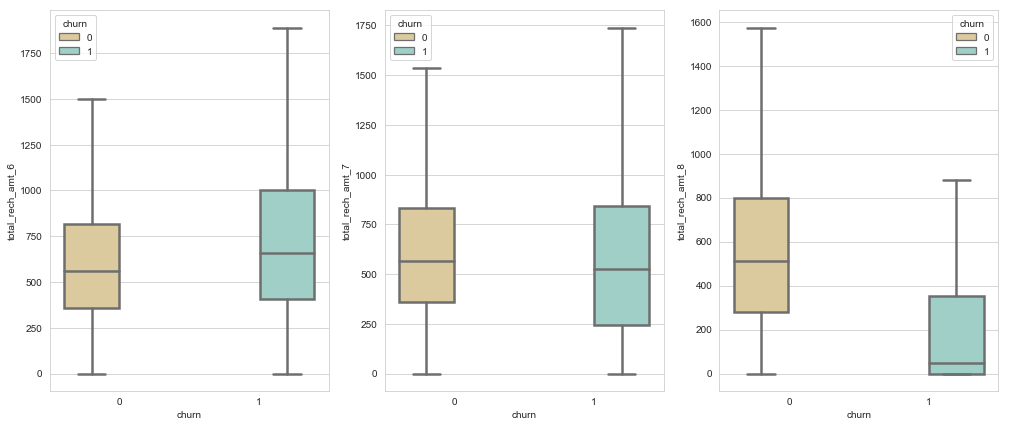

In [299]:
# let's analyze total recharge amount:
analyze_feature('total_rech_amt')

We do see a drop in the total recharge amount for churned customers.

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_data_6', 7: 'total_rech_amt_data_7', 8: 'total_rech_amt_data_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,460.70,545.73,498.19,1447.90,1500.10,1685.29
Non Churned,402.12,337.63,82.54,1047.33,1165.83,470.96


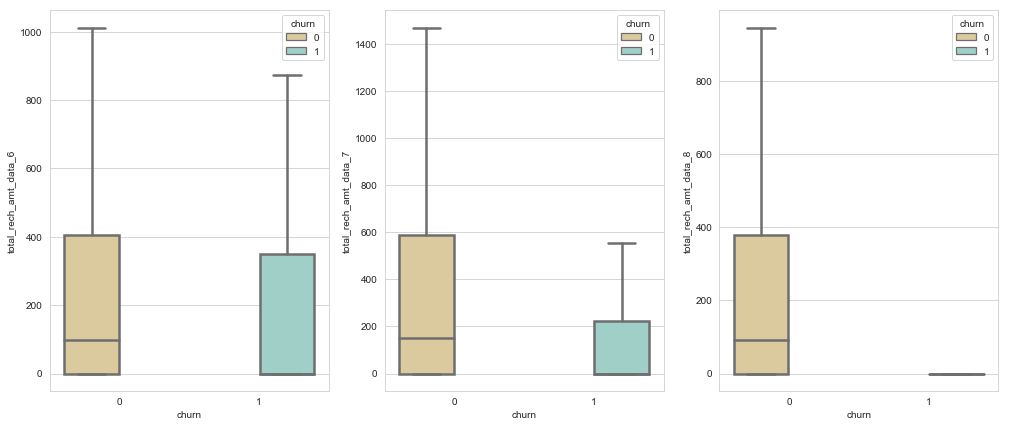

In [300]:
# let's analyze total recharge amount for data:
analyze_feature('total_rech_amt_data')

INFO 
 - We see that there is a significant drop in total recharge amount for data in 8th month (action phase) for churned customers.

Churn Stats (mean and standard deviation):
{6: 'max_rech_amt_6', 7: 'max_rech_amt_7', 8: 'max_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,168.85,173.23,166.78,171.50,176.37,170.97
Non Churned,173.98,161.00,87.89,212.49,228.85,180.84


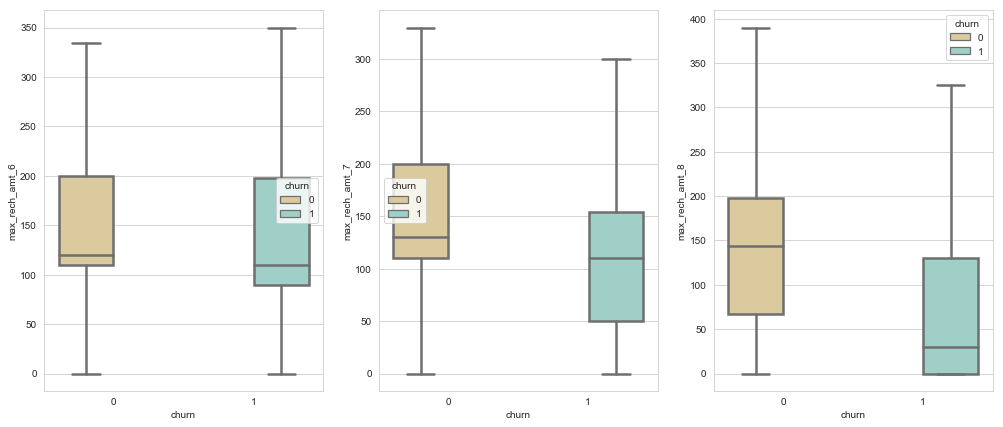

In [301]:
# let's analyze maximum recharge amount for data:
analyze_feature('max_rech_amt')

INFO 
 - We observe drop in maximum recharge amount as well.

- As we have already derived total recharge amount for data using average recharge amount for data and total recharge for data let's drop these columns.

In [302]:
# drop av_rech_amt_data and total_rech_data columns as total_rech_amt_data derived using these columns.
telecom_data.drop(['av_rech_amt_data_6','av_rech_amt_data_7'
                   ,'av_rech_amt_data_8','total_rech_data_6','total_rech_data_7','total_rech_data_8'],axis=1,inplace=True)

In [303]:
# Let us define 3 new derived columns
# total recharge amount for good phase: total_rech_amt_good_ph
# total recharge amount data for good phase: total_rech_amt_data_good_ph
# max recharge amount for good phase: max_rech_amt_good_ph

telecom_data['total_rech_amt_good_ph'] = (telecom_data.total_rech_amt_6 + telecom_data.total_rech_amt_7)/2
telecom_data['total_rech_amt_data_good_ph'] = (telecom_data.total_rech_amt_data_6 + telecom_data.total_rech_amt_data_7)/2
telecom_data['max_rech_amt_good_ph'] = (telecom_data.max_rech_amt_6 + telecom_data.max_rech_amt_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['total_rech_amt_6','total_rech_amt_7'
              ,'max_rech_amt_6','max_rech_amt_7','total_rech_amt_data_6','total_rech_amt_data_7'],axis=1,inplace=True)

# also drop total_avg_rech_amnt_good_ph as we are using the component columns defined above
telecom_data.drop('total_avg_rech_amnt_good_ph',axis=1,inplace=True)

#### last day recharge amount

In [304]:
#let's extract the last day recharge amount columns
last_day_rech_amt = telecom_data.columns[telecom_data.columns.str.contains('day')]

Churn Stats (mean and standard deviation):
{6: 'last_day_rch_amt_6', 7: 'last_day_rch_amt_7', 8: 'last_day_rch_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,100.36,102.08,97.35,140.19,138.95,145.09
Non Churned,106.67,81.52,38.43,177.76,159.67,134.92


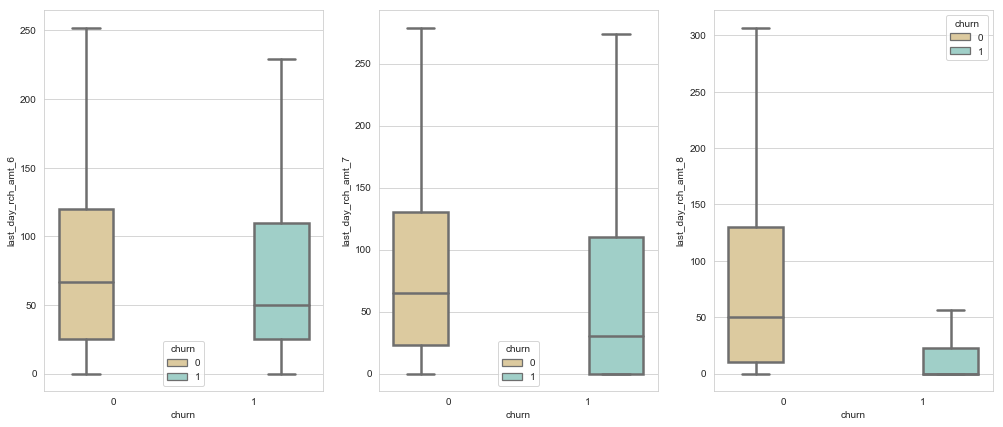

In [305]:
# let's check the mean variation in last day recharge for churned and non churned customers
analyze_feature('last_day_rch_amt')

INFO - We can see that there is a significant drop in last month recharge amount for churned customers.

In [306]:
# Let us define new derived column
# last day recharge amount for good phase: last_day_rch_amt_good_ph
telecom_data['last_day_rch_amt_good_ph'] = (telecom_data.last_day_rch_amt_6 + telecom_data.last_day_rch_amt_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['last_day_rch_amt_6','last_day_rch_amt_7'],axis=1,inplace=True)

**Other recharge related variables**

In [307]:
# Let's check other recharge related variables:
ls_recharge = telecom_data.columns[telecom_data.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [308]:
# lets check the % of NA values for recharge related variables
100*telecom_data.loc[:,ls_recharge].isnull().sum()/len(telecom_data)

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     44.148528
max_rech_data_7     43.145228
max_rech_data_8     46.825106
dtype: float64

In [309]:
# let's check the distribution for max_rech_data
telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16756.000000,17057.000000,15953.000000
mean,139.798580,140.431143,136.329217
std,118.851784,120.247247,119.531924
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


We see that the minimum value is 1 while the max is 1555 across months, which implies the missing values are cases where there was no recharge for data, let's impute the missing values by 0 indicating no recharge.

In [310]:
telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= telecom_data.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

In [311]:
# Let us define new derived column
# maximum recharge for data for good phase: max_rech_data_good_ph
telecom_data['max_rech_data_good_ph'] = (telecom_data.max_rech_data_6 + telecom_data.max_rech_data_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['max_rech_data_6','max_rech_data_7'],axis=1,inplace=True)

In [312]:
# let's check total recharge number
ls_tot_recharge_num = telecom_data.columns[telecom_data.columns.str.contains('total_rech_num')]

# check the summary stats:
print(telecom_data.loc[:,ls_tot_recharge_num].describe())

# let's check the median variation in total recharge numbers for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,ls_tot_recharge_num].median()
              ,telecom_data.loc[telecom_data.churn==1,ls_tot_recharge_num].median()],index={'Non Churned','Churned'})

       total_rech_num_6  total_rech_num_7  total_rech_num_8
count      30001.000000      30001.000000      30001.000000
mean          11.851005         11.718843          9.972868
std            9.429132          9.432418          9.274370
min            0.000000          0.000000          0.000000
25%            6.000000          6.000000          4.000000
50%            9.000000          9.000000          8.000000
75%           15.000000         15.000000         13.000000
max          307.000000        138.000000        196.000000


,total_rech_num_6,total_rech_num_7,total_rech_num_8
Churned,9.0,9.0,8.0
Non Churned,11.0,9.0,3.0


while there are some outliers in 6th month overall distribution is similar for 6,7 and 8th month, we do see a drop in median recharge numbers

In [313]:
# Let us define new derived column
# total recharge number for good phase: total_rech_num_good_ph
telecom_data['total_rech_num_good_ph'] = (telecom_data.total_rech_num_6 + telecom_data.total_rech_num_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['total_rech_num_6','total_rech_num_7'],axis=1,inplace=True)

#### 2G and 3G usage related variables

In [314]:
#let's extract the 2G and 3G usage related columns
typ_2g_or_3g = telecom_data.columns[telecom_data.columns.str.contains('2g|3g',regex=True)]

In [315]:
#let us check the % of NA values present
telecom_data.loc[:,typ_2g_or_3g].isnull().sum()/len(telecom_data.loc[:,typ_2g_or_3g])

count_rech_2g_6    0.441485
count_rech_2g_7    0.431452
count_rech_2g_8    0.468251
count_rech_3g_6    0.441485
count_rech_3g_7    0.431452
count_rech_3g_8    0.468251
vol_2g_mb_6        0.000000
vol_2g_mb_7        0.000000
vol_2g_mb_8        0.000000
vol_3g_mb_6        0.000000
vol_3g_mb_7        0.000000
vol_3g_mb_8        0.000000
arpu_3g_6          0.441485
arpu_3g_7          0.431452
arpu_3g_8          0.468251
arpu_2g_6          0.441485
arpu_2g_7          0.431452
arpu_2g_8          0.468251
monthly_2g_6       0.000000
monthly_2g_7       0.000000
monthly_2g_8       0.000000
sachet_2g_6        0.000000
sachet_2g_7        0.000000
sachet_2g_8        0.000000
monthly_3g_6       0.000000
monthly_3g_7       0.000000
monthly_3g_8       0.000000
sachet_3g_6        0.000000
sachet_3g_7        0.000000
sachet_3g_8        0.000000
aug_vbc_3g         0.000000
jul_vbc_3g         0.000000
jun_vbc_3g         0.000000
sep_vbc_3g         0.000000
dtype: float64

We see from above that about 60% values are not available for count of recharge and average revenue for 2G/3G per user. As we aleady have 2G/3G volume usage based data available, let's drop these columns.

In [316]:
telecom_data.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

In [317]:
# let's extract volume of 2G and 3G usage columns
volume_of_usage_3g_and_2g = telecom_data.columns[telecom_data.columns.str.contains('vol_2g|vol_3g',regex=True)]

# let's check the summary stats:
print(telecom_data.loc[:,volume_of_usage_3g_and_2g].describe())

        vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8   vol_3g_mb_6   vol_3g_mb_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean     126.522185    125.097326    105.913072    344.258568    370.196701   
std      330.530793    331.548010    313.384838    913.747778    915.525911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.050000      0.000000      0.000000      0.000000   
75%       83.450000     77.770000     51.650000    358.740000    410.700000   
max    10285.900000   7873.550000  11117.610000  45735.400000  28144.120000   

        vol_3g_mb_8  
count  30001.000000  
mean     351.493998  
std      919.021056  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%      356.190000  
max    30036.060000  


In [318]:
# let's check the mean variation in volume of 2G/3G usage for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,volume_of_usage_3g_and_2g].mean()
              ,telecom_data.loc[telecom_data.churn==1,volume_of_usage_3g_and_2g].mean()],index={'Non Churned','Churned'})

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
Churned,128.074912,128.464723,113.562745,350.312362,384.200039,375.776694
Non Churned,109.604104,88.407121,22.564389,278.298136,217.620278,86.916594


We have two observations from above:
* the 2G and 3G usage for churned customers drops in 8th month 
* we also see that average 3G usage is higher for non-churned customers indicating that churned customers might be from areas where 3G service is not properly available.

In [319]:
# Let us define two new derived columns
# 2G volume usage for good phase: vol_2g_mb_good_ph
# 3G volume usage for good phase: vol_3g_mb_good_ph
telecom_data['vol_2g_mb_good_ph'] = (telecom_data.vol_2g_mb_6 + telecom_data.vol_2g_mb_7)/2
telecom_data['vol_3g_mb_good_ph'] = (telecom_data.vol_3g_mb_6 + telecom_data.vol_3g_mb_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['vol_2g_mb_6','vol_2g_mb_7'
              ,'vol_3g_mb_6','vol_3g_mb_7'],axis=1,inplace=True)

In [320]:
# let's check monthly 2G/3G service schemes
monthly_2g_3g = telecom_data.columns[telecom_data.columns.str.contains('monthly_2g|monthly_3g',regex=True)]

# let's check the summary stats:
print(telecom_data.loc[:,monthly_2g_3g].describe())

       monthly_2g_6  monthly_2g_7  monthly_2g_8  monthly_3g_6  monthly_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       0.174494      0.183261      0.153628      0.217759      0.229026   
std        0.434953      0.450423      0.406486      0.613199      0.659125   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        4.000000      5.000000      5.000000     14.000000     16.000000   

       monthly_3g_8  
count  30001.000000  
mean       0.211026  
std        0.617549  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       16.000000  


In [321]:
# let's check the mean variation in monthly schemes of 2G/3G usage for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,monthly_2g_3g].mean()
              ,telecom_data.loc[telecom_data.churn==1,monthly_2g_3g].mean()],index={'Non Churned','Churned'})

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Churned,0.182030,0.193675,0.165581,0.219950,0.237017,0.225227
Non Churned,0.092387,0.069786,0.023394,0.193894,0.141951,0.056305


Again we see a drop in monthly subscription for churned customers in action month (8th month) as compared ot non churned customers.

In [322]:
# Let us define two new derived columns
# 2G monthly for good phase: monthly_2g_good_ph
# 3G monthly for good phase: monthly_3g_good_ph
telecom_data['monthly_2g_good_ph'] = (telecom_data.monthly_2g_6 + telecom_data.monthly_2g_7)/2
telecom_data['monthly_3g_good_ph'] = (telecom_data.monthly_3g_6 + telecom_data.monthly_3g_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['monthly_2g_6','monthly_2g_7'
              ,'monthly_3g_6','monthly_3g_7'],axis=1,inplace=True)

#### volume based cost

In [323]:
# let us rename month named vbc columns to 6,7,8,9 format
telecom_data.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# drop 9th month column as it is not needed
telecom_data.drop('vbc_3g_9',axis=1,inplace=True)

Churn Stats (mean and standard deviation):
{6: 'vbc_3g_6', 7: 'vbc_3g_7', 8: 'vbc_3g_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,162.62,186.49,180.93,421.60,452.97,433.33
Non Churned,113.95,95.86,40.64,356.49,311.75,210.34


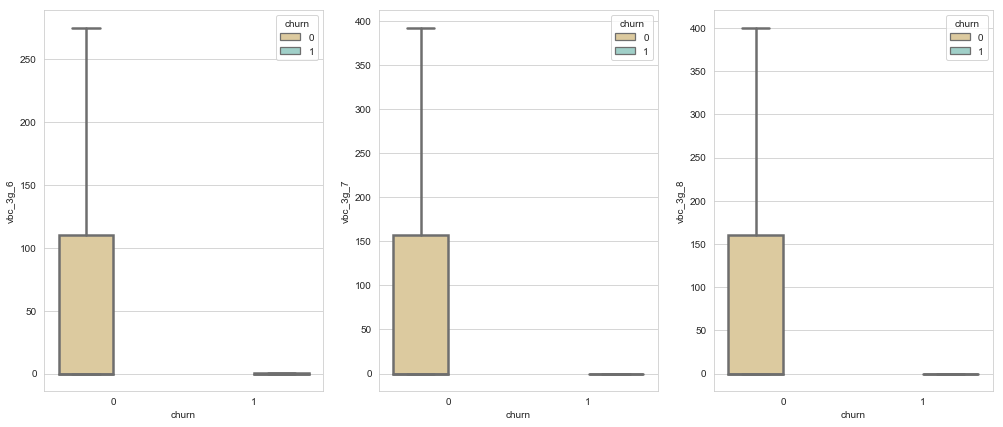

In [324]:
# let's check the volumne based cost for 3G
volumn_based_cost_3g = telecom_data.columns[telecom_data.columns.str.contains('vbc_3g')]

# analyze volume based cost
analyze_feature('vbc_3g')

We can clearly see that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month.

In [325]:
# Let us define new derived columns
# 3g volume based cost for good phase: vbc_3g_good_ph
telecom_data['vbc_3g_good_ph'] = (telecom_data['vbc_3g_6'] + telecom_data['vbc_3g_7'])/2

# drop the original columns as these are not longer required
telecom_data.drop(['vbc_3g_6','vbc_3g_7'],axis=1,inplace=True)

#### sachet subscription

In [326]:
# let's check sachet subscription for 2G/3G
sachet_2g_or_3g = telecom_data.columns[telecom_data.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

print(telecom_data.loc[:,sachet_2g_or_3g].describe())

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,sachet_2g_or_3g].mean()
              ,telecom_data.loc[telecom_data.churn==1,sachet_2g_or_3g].mean()],index={'Non Churned','Churned'})

        sachet_2g_6   sachet_2g_7   sachet_2g_8   sachet_3g_6   sachet_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       1.066064      1.214026      1.054865      0.209393      0.227492   
std        2.507197      2.736158      2.535940      0.985674      1.089929   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max       42.000000     48.000000     44.000000     29.000000     35.000000   

        sachet_3g_8  
count  30001.000000  
mean       0.202393  
std        1.100107  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       41.000000  


,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Churned,1.069289,1.244368,1.127042,0.206703,0.228247,0.215110
Non Churned,1.030928,0.883426,0.268438,0.238699,0.219270,0.063838


There is a steep drop in sachet services in 8th month for churned cutsomers as compared to non churned customers

In [327]:
# Let us define two new derived columns
# 2G sachet for good phase: sachet_2g_good_ph
# 3G sachet for good phase: sachet_3g_good_ph
telecom_data['sachet_2g_good_ph'] = (telecom_data.sachet_2g_6 + telecom_data.sachet_2g_7)/2
telecom_data['sachet_3g_good_ph'] = (telecom_data.sachet_3g_6 + telecom_data.sachet_3g_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['sachet_2g_6','sachet_2g_7'
              ,'sachet_3g_6','sachet_3g_7'],axis=1,inplace=True)

#### Age on network

In [328]:
# let's check the age on n/w for churned and non churned customers
print(telecom_data.loc[telecom_data.churn==1,'aon'].mean())
print(telecom_data.loc[telecom_data.churn==0,'aon'].mean())

859.3049167327517
1241.4973252301759


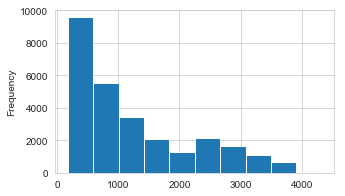

In [329]:
# let's check the age distribution for non churned customers
plt.figure(figsize=(5,3))
telecom_data.loc[telecom_data.churn==0,'aon'].plot.hist()

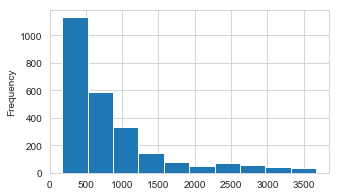

In [330]:
# let's check the age distribution for churned customers
plt.figure(figsize=(5,3))
telecom_data.loc[telecom_data.churn==1,'aon'].plot.hist()

We see from above that most of the churn cases are happening before age 1500 days.

In [331]:
# let's check the circle id values
telecom_data.circle_id.unique()

# let's drop this column as there is only one circle id
telecom_data.drop('circle_id',inplace=True,axis=1)

#### date related variables

In [332]:
# extract the date columns
date_columns = telecom_data.columns[telecom_data.columns.str.contains('date')]

# convert to datetime
for date_col in list(date_columns):
    telecom_data[date_col]= pd.to_datetime(telecom_data[date_col])

In [333]:
print(telecom_data.last_date_of_month_6.dt.day.unique(),telecom_data.last_date_of_month_7.dt.day.unique()
      ,telecom_data.last_date_of_month_8.dt.day.unique())

# as only 1 unique value last day of month is present these columns are not adding much information
# let us drop the columns
telecom_data.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],axis=1,inplace=True)

[30] [ 31.  nan] [ 31.  nan]


In [334]:
# let's extract the day of last recharge
telecom_data['day_of_last_rech_6'] =  telecom_data.date_of_last_rech_6.dt.day
telecom_data['day_of_last_rech_7'] =  telecom_data.date_of_last_rech_7.dt.day
telecom_data['day_of_last_rech_8'] =  telecom_data.date_of_last_rech_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,dt_of_last_rech_cols].median()
              ,telecom_data.loc[telecom_data.churn==1,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
Churned,28.0,29.0,29.0
Non Churned,28.0,27.0,26.0


We can see that the median value for last recharge is bit lower for churned customers

In [335]:
# let's define a new derived column indicating the shift in day of last recharge

telecom_data['day_of_last_rech_shift'] = telecom_data.day_of_last_rech_8 -(telecom_data.day_of_last_rech_6+telecom_data.day_of_last_rech_7)/2

In [336]:
# let's check how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,['day_of_last_rech_shift']].median()
              ,telecom_data.loc[telecom_data.churn==1,['day_of_last_rech_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_shift
Churned,0.5
Non Churned,-2.0


We can clearly see that a large negative shift is highly indicative of churn

In [337]:
# let's delete the other colummns derived as are no longer required
telecom_data.drop(['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8'],axis=1,inplace=True)

In [338]:
# let's extract the day of last recharge for data
telecom_data['day_of_last_rech_data_6'] =  telecom_data.date_of_last_rech_data_6.dt.day
telecom_data['day_of_last_rech_data_7'] =  telecom_data.date_of_last_rech_data_7.dt.day
telecom_data['day_of_last_rech_data_8'] =  telecom_data.date_of_last_rech_data_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']

pd.DataFrame([telecom_data.loc[telecom_data.churn==0,dt_of_last_rech_cols].median()
              ,telecom_data.loc[telecom_data.churn==1,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_6,day_of_last_rech_data_7,day_of_last_rech_data_8
Churned,22.0,24.0,23.0
Non Churned,23.0,20.0,15.0


In [339]:
# let's define a new derived column indicating the shift in day of last data recharge

telecom_data['day_of_last_rech_data_shift'] = telecom_data.day_of_last_rech_data_8 -(telecom_data.day_of_last_rech_data_6+telecom_data.day_of_last_rech_data_7)/2

In [340]:
# let's check how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,['day_of_last_rech_data_shift']].median()
              ,telecom_data.loc[telecom_data.churn==1,['day_of_last_rech_data_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_shift
Churned,-0.5
Non Churned,-6.0


In [341]:
# let's delete the other colummns derived as are no longer required
telecom_data.drop(['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8'],axis=1,inplace=True)

In [342]:
# let us drop the date columns as we have derived day of month variables from them
telecom_data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1,inplace=True)
telecom_data.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1,inplace=True)

#### average revenue per user

Churn Stats (mean and standard deviation):
{6: 'arpu_6', 7: 'arpu_7', 8: 'arpu_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,549.23,562.86,533.26,447.05,474.10,504.14
Non Churned,659.36,538.11,239.87,579.28,537.32,386.45


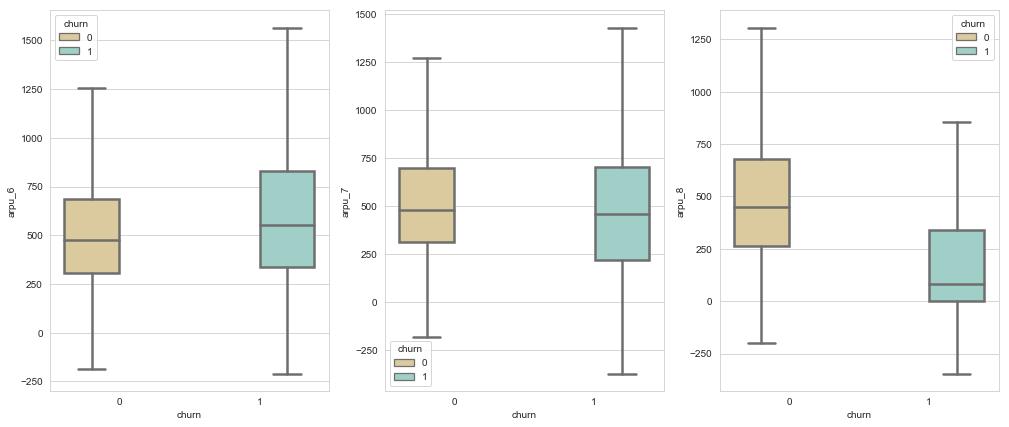

In [343]:
# extract columns for average revenue per user
arpu_cols = telecom_data.columns[telecom_data.columns.str.contains('arpu_')]

# analyze arpu
analyze_feature('arpu')

We can see that arpu also drops signficantly in action phase for churned customers

In [344]:
# Let us define new derived columns
# arpu for good phase: arpu_good_ph
telecom_data['arpu_good_ph'] = (telecom_data.arpu_6 + telecom_data.arpu_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['arpu_6','arpu_7'],axis=1,inplace=True)

#### Minutes of Usage related variables

In [345]:
# let's derive minutes of usage columns
mou_cols = telecom_data.columns[telecom_data.columns.str.contains('mou')]

In [346]:
mou_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [347]:
# let's check if there are any zero variation columns among these
zero_var_cols = telecom_data.loc[:,mou_cols].std()[telecom_data.loc[:,mou_cols].std()==0].index.values

zero_var_cols

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], dtype=object)

In [348]:
# let's drop these columns
telecom_data.drop(list(zero_var_cols),axis=1,inplace=True)

In [349]:
# let's check the % of null values among mou variables
mou_cols = telecom_data.columns[telecom_data.columns.str.contains('mou')]
100*telecom_data.loc[:,mou_cols].isnull().sum()/len(telecom_data.loc[:,mou_cols])

onnet_mou_6         1.816606
onnet_mou_7         1.789940
onnet_mou_8         3.913203
offnet_mou_6        1.816606
offnet_mou_7        1.789940
offnet_mou_8        3.913203
roam_ic_mou_6       1.816606
roam_ic_mou_7       1.789940
roam_ic_mou_8       3.913203
roam_og_mou_6       1.816606
roam_og_mou_7       1.789940
roam_og_mou_8       3.913203
loc_og_t2t_mou_6    1.816606
loc_og_t2t_mou_7    1.789940
loc_og_t2t_mou_8    3.913203
loc_og_t2m_mou_6    1.816606
loc_og_t2m_mou_7    1.789940
loc_og_t2m_mou_8    3.913203
loc_og_t2f_mou_6    1.816606
loc_og_t2f_mou_7    1.789940
loc_og_t2f_mou_8    3.913203
loc_og_t2c_mou_6    1.816606
loc_og_t2c_mou_7    1.789940
loc_og_t2c_mou_8    3.913203
loc_og_mou_6        1.816606
loc_og_mou_7        1.789940
loc_og_mou_8        3.913203
std_og_t2t_mou_6    1.816606
std_og_t2t_mou_7    1.789940
std_og_t2t_mou_8    3.913203
                      ...   
loc_ic_t2m_mou_6    1.816606
loc_ic_t2m_mou_7    1.789940
loc_ic_t2m_mou_8    3.913203
loc_ic_t2f_mou

In [350]:
# let's check the maximum % of missing value
100*telecom_data.loc[:,mou_cols].isnull().sum().max()/len(telecom_data.loc[:,mou_cols])

3.9132028932368921

So for all minutes of usage columns the maximum missing % is 3.19 which seems that in these case the mobile has not been used at all for that particular call type(ic,std etc.), thus it is safe to assume that we can impute the missing values with zero.

In [351]:
# replaceing null values by 0 for minutes of usage variables
telecom_data.loc[:,mou_cols] = telecom_data.loc[:,mou_cols].replace(np.NaN,0)

Lets now now analyze the sub groups of minutes of usage, following groups are there:
* og: outgoing calls
* ic: incoming calls
* offnet: all kinds of calls outside operator network
* onnet: all kinds of call within same operator network

Let us start by analyzing minutes for usage variables for month 6

In [352]:
# let's collect mou variables for month 6
mou_6 = telecom_data.columns[telecom_data.columns.str.contains('mou_6')]

In [353]:
mou_6

Index(['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6',
       'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6',
       'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6',
       'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6',
       'spl_og_mou_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6',
       'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6',
       'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
       'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

Let's check the outgoing mou variables.

In [354]:
mou_og_cols6 = telecom_data.columns[telecom_data.columns.str.contains('.*_og_.*mou_6',regex=True)]

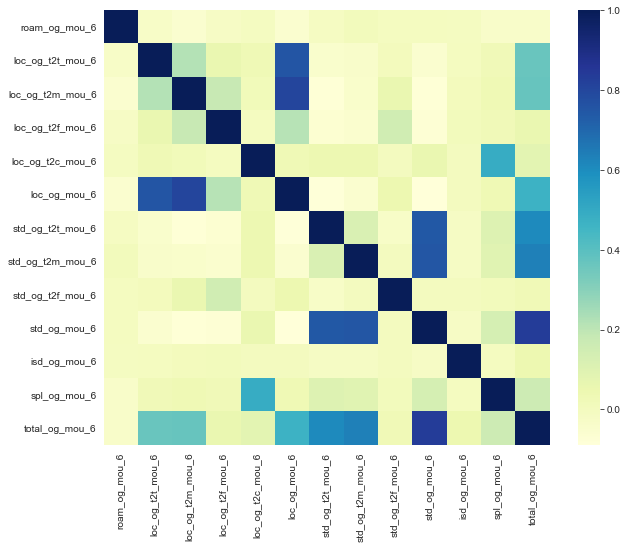

In [355]:
#sns.heatmap(telecom_data.loc[:,mou_cols6].corr())

# let us create a correlation matrix heatmap among quantitative varibales
plt.figure(figsize=(10, 8))
sns.heatmap(telecom_data.loc[:,mou_og_cols6].corr(), cmap="YlGnBu")
plt.show()

After analyzing the variables, we acertain the following rlationships among variables: 

* **total_og_mou_6 = loc_og_mou_6+std_og_mou_6+spl_og_mou_6+isd_og_mou_6+ roam_og_mou_6+og_others_6**
* **std_og_mou_6 = std_og_t2m_mou_6+std_og_t2t_mou_6+std_og_t2f_mou_6 + std_og_2tc_mou_6**
* **loc_og_mou_6 = loc_og_t2m_mou_6+loc_og_t2t_mou_6+loc_og_t2f_mou_6 + loc_og_2tc_mou_6**

In [356]:
## fact checking!!
print(telecom_data.loc[7,'total_og_mou_6'],telecom_data.loc[7,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())

print(telecom_data.loc[7,'std_og_mou_6'],telecom_data.loc[7,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6','std_og_loc_mou_6']].sum())

print(telecom_data.loc[7,'loc_og_mou_6'],telecom_data.loc[7,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_2tc_mou_6']].sum())

487.53 487.52000000000004
60.86 60.849999999999994
422.16 422.15


In [357]:
# As total_og_mou_6, std_og_mou_6 and loc_og_mou_6 already have component variables present in dataset
# let's remove these columns for all months from the data set

ls_total_og_cols = telecom_data.columns[telecom_data.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]

print(ls_total_og_cols)

telecom_data.drop(ls_total_og_cols,axis=1,inplace=True)

Index(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8'],
      dtype='object')


In [358]:
# let's define good phase derived variables for all og components:
telecom_data['spl_og_mou_good_ph'] = (telecom_data.spl_og_mou_6 + telecom_data.spl_og_mou_7)/2
telecom_data['isd_og_mou_good_ph'] = (telecom_data.isd_og_mou_6 + telecom_data.isd_og_mou_7)/2
telecom_data['roam_og_mou_good_ph'] = (telecom_data.roam_og_mou_6 + telecom_data.roam_og_mou_7)/2
telecom_data['std_og_t2m_mou_good_ph'] = (telecom_data.std_og_t2m_mou_6 + telecom_data.std_og_t2m_mou_7)/2
telecom_data['std_og_t2t_mou_good_ph'] = (telecom_data.std_og_t2t_mou_6 + telecom_data.std_og_t2t_mou_7)/2
telecom_data['std_og_t2f_mou_good_ph'] = (telecom_data.std_og_t2f_mou_6 + telecom_data.std_og_t2f_mou_7)/2

telecom_data['loc_og_t2m_mou_good_ph'] = (telecom_data.loc_og_t2m_mou_6 + telecom_data.loc_og_t2m_mou_7)/2
telecom_data['loc_og_t2t_mou_good_ph'] = (telecom_data.loc_og_t2t_mou_6 + telecom_data.loc_og_t2t_mou_7)/2
telecom_data['loc_og_t2f_mou_good_ph'] = (telecom_data.loc_og_t2f_mou_6 + telecom_data.loc_og_t2f_mou_7)/2
telecom_data['loc_og_t2c_mou_good_ph'] = (telecom_data.loc_og_t2c_mou_6 + telecom_data.loc_og_t2c_mou_7)/2

In [359]:
# drop all the original og mou variables
ls_og = telecom_data.columns[telecom_data.columns.str.contains('.*_og_.*mou_6|.*_og_.*mou_7',regex=True)]

print(ls_og)

telecom_data.drop(ls_og,axis=1,inplace=True)

Index(['roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6',
       'spl_og_mou_7'],
      dtype='object')


**Let's check for incoming mou variables**

In [360]:
mou_ic_cols6 = telecom_data.columns[telecom_data.columns.str.contains('.*_ic_.*mou_6',regex=True)]

mou_ic_cols6

Index(['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

As with og mou variables above, we observe the following relationship among ic (incoming)mou variables:

* **total_ic_mou_6 = loc_ic_mou_6 + std_ic_mou_6 + roam_ic_mou_6 + isd_ic_mou_6 + spl_ic_mou_6 + ic_others_6**
* **loc_ic_mou_6 = loc_ic_t2t_mou_6 + loc_ic_t2m_mou_6+loc_ic_t2f_mou_6+loc_ic_t2c_mou_6**
* **std_ic_mou_6 = std_ic_t2t_mou_6 + std_ic_t2m_mou_6 + std_ic_t2f_mou_6+std_ic_t2c_mou_6**

In [361]:
# fact checking!!
print(telecom_data.loc[7,'total_ic_mou_6'],telecom_data.loc[7,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())

print(telecom_data.loc[7,'loc_ic_mou_6'],telecom_data.loc[7,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_t2c_mou_6']].sum())

print(telecom_data.loc[7,'std_ic_mou_6'],telecom_data.loc[7,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2c_mou_6']].sum())

626.46 626.92
427.88 427.86
180.54 180.51999999999998


In [362]:
# As total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 already have component variables present in dataset
# let's remove these columns for all months from the data set

ls_total_ic_cols = telecom_data.columns[telecom_data.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]

print(ls_total_ic_cols)

telecom_data.drop(ls_total_ic_cols,axis=1,inplace=True)

Index(['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8'],
      dtype='object')


In [363]:
# let's define good phase derive variables for all ic components:
telecom_data['spl_ic_mou_good_ph'] = (telecom_data.spl_ic_mou_6 + telecom_data.spl_ic_mou_7)/2
telecom_data['isd_ic_mou_good_ph'] = (telecom_data.isd_ic_mou_6 + telecom_data.isd_ic_mou_7)/2
telecom_data['roam_ic_mou_good_ph'] = (telecom_data.roam_ic_mou_6 + telecom_data.roam_ic_mou_7)/2
telecom_data['std_ic_t2m_mou_good_ph'] = (telecom_data.std_ic_t2m_mou_6 + telecom_data.std_ic_t2m_mou_7)/2
telecom_data['std_ic_t2t_mou_good_ph'] = (telecom_data.std_ic_t2t_mou_6 + telecom_data.std_ic_t2t_mou_7)/2
telecom_data['std_ic_t2f_mou_good_ph'] = (telecom_data.std_ic_t2f_mou_6 + telecom_data.std_ic_t2f_mou_7)/2

telecom_data['loc_ic_t2m_mou_good_ph'] = (telecom_data.loc_ic_t2m_mou_6 + telecom_data.loc_ic_t2m_mou_7)/2
telecom_data['loc_ic_t2t_mou_good_ph'] = (telecom_data.loc_ic_t2t_mou_6 + telecom_data.loc_ic_t2t_mou_7)/2
telecom_data['loc_ic_t2f_mou_good_ph'] = (telecom_data.loc_ic_t2f_mou_6 + telecom_data.loc_ic_t2f_mou_7)/2

In [364]:
# drop all the original og mou variables
ls_ic = telecom_data.columns[telecom_data.columns.str.contains('.*_ic_.*mou_6|.*_ic_.*mou_7',regex=True)]

print(ls_ic)

telecom_data.drop(ls_ic,axis=1,inplace=True)

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7',
       'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7',
       'isd_ic_mou_6', 'isd_ic_mou_7'],
      dtype='object')


**offnet usage**

In [365]:
 offnet_cols = telecom_data.columns[telecom_data.columns.str.contains('offnet',regex=True)]

Churn Stats (mean and standard deviation):
{6: 'offnet_mou_6', 7: 'offnet_mou_7', 8: 'offnet_mou_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,364.92,377.79,352.68,463.15,489.51,490.20
Non Churned,469.29,381.51,143.30,650.11,591.94,325.64


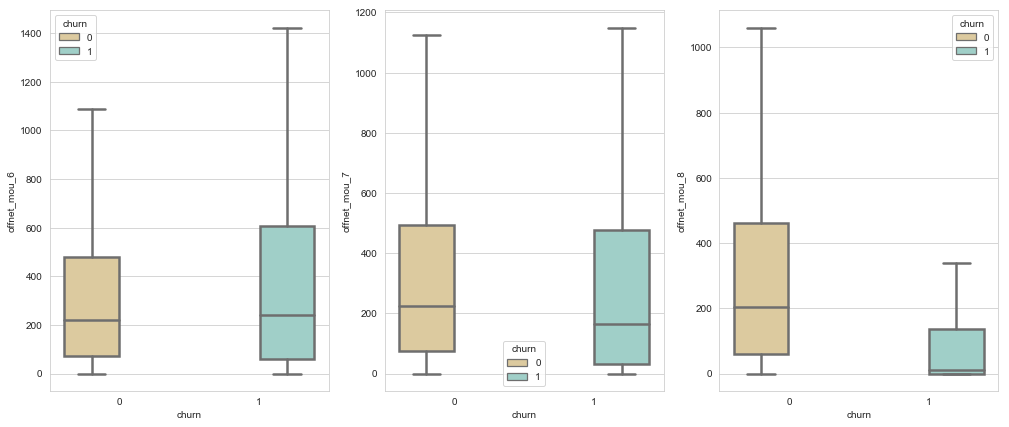

In [366]:
# let's analyze for offnet mou values for churned and non churned customers
analyze_feature('offnet_mou')

there is a substantial decrease in offnet mou for action month.

In [367]:
# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
telecom_data['offnet_mou_good_ph'] = (telecom_data.offnet_mou_6 + telecom_data.offnet_mou_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['offnet_mou_6','offnet_mou_7'],axis=1,inplace=True)

#### minutes of usage related variables within same operator network

In [368]:
#let's extract the minutes of usage related columns
onnet_cols =  telecom_data.columns[telecom_data.columns.str.contains('^onnet.*mou',regex=True)]

Churn Stats (mean and standard deviation):
{6: 'onnet_mou_6', 7: 'onnet_mou_7', 8: 'onnet_mou_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,250.86,265.59,244.98,441.95,474.22,466.25
Non Churned,369.03,292.15,115.71,610.30,538.45,341.05


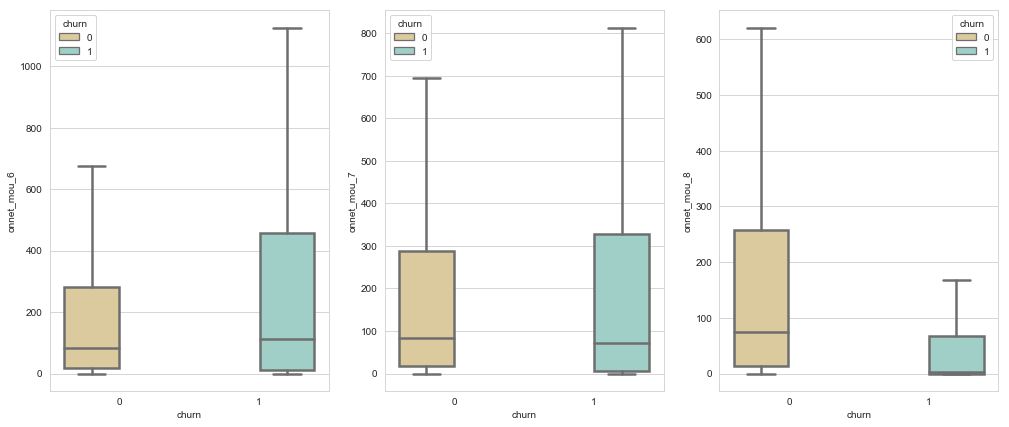

In [369]:
# let's analyze for offnet mou values for churned and non churned customers
analyze_feature('onnet_mou')

We again see that there is a drop in minutes of usage in the action month (8th month) for churned customers

In [370]:
# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
telecom_data['onnet_mou_good_ph'] = (telecom_data.onnet_mou_6 + telecom_data.onnet_mou_7)/2

# drop the original columns as these are not longer required
telecom_data.drop(['onnet_mou_6','onnet_mou_7'],axis=1,inplace=True)

In [371]:
# let's check summary stats for oc others and ic others mou
ls_others = telecom_data.columns[telecom_data.columns.str.contains('_others')]

print(telecom_data.loc[:,ls_others].describe())

        og_others_6   og_others_7   og_others_8   ic_others_6   ic_others_7  \
count  29456.000000  29464.000000  28827.000000  29456.000000  29464.000000   
mean       0.673323      0.043687      0.059953      1.174790      1.527682   
std        4.144797      2.701071      3.381939     14.113843     16.141140   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.060000      0.000000   
max      609.810000    370.130000    394.930000   1344.140000   1495.940000   

        ic_others_8  
count  28827.000000  
mean       1.274322  
std       13.038515  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.060000  
max     1209.860000  


we see from above that very few values are availabe for oc_others and ic_others.

In [372]:
# Let us define two new derived columns
# OG others for good phase: og_others_good_ph
# IC otherd for good phase: ic_others_good_ph
telecom_data['og_others_good_ph'] = (telecom_data.og_others_6 + telecom_data.og_others_7)/2
telecom_data['ic_others_good_ph'] = (telecom_data.ic_others_6 + telecom_data.ic_others_6)/2


# drop the original columns as these are not longer required
telecom_data.drop(['og_others_6','og_others_7','ic_others_6','ic_others_7'],axis=1,inplace=True)

Let's check if there are any more columns with more than 20% NA values remaining.

In [373]:
is_more_than_20 = telecom_data.isnull().sum()/len(telecom_data) > 0.2
100*telecom_data.loc[:,is_more_than_20].isnull().sum()/len(telecom_data.loc[:,is_more_than_20])

night_pck_user_6               44.148528
night_pck_user_7               43.145228
night_pck_user_8               46.825106
fb_user_6                      44.148528
fb_user_7                      43.145228
fb_user_8                      46.825106
day_of_last_rech_data_shift    59.904670
dtype: float64

In [374]:
# lets drop these columns as we have already captured internet volume usage and total data amount recharged.
# also we have captured day of last recharge shift as well.
telecom_data.drop(telecom_data.columns[is_more_than_20],axis=1,inplace=True)

In [375]:
# let's check how many variables are remaining!!
telecom_data.shape

(30001, 78)

In [376]:
is_na = telecom_data.isnull().sum()/len(telecom_data) > 0
100*telecom_data.loc[:,is_na].isnull().sum()/len(telecom_data.loc[:,is_na])

og_others_8               3.913203
ic_others_8               3.913203
day_of_last_rech_shift    2.306590
og_others_good_ph         2.606580
ic_others_good_ph         1.816606
dtype: float64

We can observe that these have very few values a NA indicating that there is no usage in these variables by customer.
Let's impute these values by 0.

In [377]:
telecom_data.loc[:,:] = telecom_data.loc[:,:].replace(np.NaN,0)

### Model building

In this section we will build multiple machine learning models to accurately predict customers who might churn in the action phase (8th Month)

In [378]:
# Putting feature variable to X
X = telecom_data.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_data['churn']

#### Additional feature engineering

We will do some additional feature transformation to achieve better accuracy in our predictive model. We know from EDA above that a drop in action phase parameter as compared to good phase value is highly indicative of a likely churn, let's use this heuristic to derive action phase column which is actually the difference between good phase feature value and action phase (8th month) feature value and discard the 8th month feature columns.

In [379]:
# extract good phase feature list and 8th month feature list
f_good_ph = X.loc[:,X.columns.str.contains('good_ph')]
f_8 = X.loc[:,X.columns.str.contains('_8')]

In [380]:
# define function to calculate difference between 8th month feature and good phase feature
def FindDiff(x,y):      
    diff = 0.00
    if np.isnan(x) and np.isnan(y):
        diff = np.NAN
    elif np.isnan(y) and ~np.isnan(x):
        diff = x
    elif ~np.isnan(y)and np.isnan(x):
        diff = -y
    else:
        diff = x-y

    return(diff)    

In [381]:
# create a feature data frame copy from original features
X_diff = X.copy()

In [382]:
# extract features without any good phase or 8th month indicator.
features_to_explore = set(map(lambda x: x.replace("_good_ph", ""), f_good_ph))
features_to_explore

{'arpu',
 'ic_others',
 'isd_ic_mou',
 'isd_og_mou',
 'last_day_rch_amt',
 'loc_ic_t2f_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2t_mou',
 'loc_og_t2c_mou',
 'loc_og_t2f_mou',
 'loc_og_t2m_mou',
 'loc_og_t2t_mou',
 'max_rech_amt',
 'max_rech_data',
 'monthly_2g',
 'monthly_3g',
 'offnet_mou',
 'og_others',
 'onnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'sachet_2g',
 'sachet_3g',
 'spl_ic_mou',
 'spl_og_mou',
 'std_ic_t2f_mou',
 'std_ic_t2m_mou',
 'std_ic_t2t_mou',
 'std_og_t2f_mou',
 'std_og_t2m_mou',
 'std_og_t2t_mou',
 'total_rech_amt',
 'total_rech_amt_data',
 'total_rech_num',
 'vbc_3g',
 'vol_2g_mb',
 'vol_3g_mb'}

In [383]:
# create new derived columns for action phase.
for feat in features_to_explore:
    X_diff[feat+'_act_ph']= np.vectorize(FindDiff)(X_diff[feat+'_8'], X_diff[feat+'_good_ph'])

In [384]:
# drop 8th month columns as we have already derived action phase columns.
X_diff.drop(f_8,axis=1,inplace=True)

#### feature standardisation

Let's do a feature standardisation

In [385]:
# import standard scalar
from sklearn.preprocessing import StandardScaler

# extract columns
cols = X_diff.columns

# apply standard scalar
scaler = StandardScaler()

# produce scaled features
X_scaled = scaler.fit_transform(X_diff)

# convert to data frame
X_scaled = pd.DataFrame(X_diff, columns=cols)


In [386]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)

Let's define a function to print out evaluation metrics, as we have customer churn as positive class (1) we would try to maximize sensitivity at the same time trying to keep auc_score at a good level.

In [387]:
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score

# define function to calculate and print model metrics.
def printMetrics(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    print('Confusion Matrix: \n',cp)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ",specificity)
    print("AUC Score: ", roc_auc_score(y_test,y_pred)) 
    print("Precision: ",precision)
    print("f1 Score: ",f1_score(y_test,y_pred))

In [388]:
# let's start by building as basic logistic regression model
from sklearn.linear_model import LogisticRegression
lsr = LogisticRegression()

In [389]:
lsr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [390]:
# predict results on test
y_pred = lsr.predict(X_test)

In [391]:
# print model evaluation metrics
printMetrics(y_test,y_pred)

Confusion Matrix: 
 [[8118  113]
 [ 505  265]]
Sensitivity:  0.344155844156
Specificity:  0.986271412951
AUC Score:  0.665213628553
Precision:  0.701058201058
f1 Score:  0.461672473868


We do see from above that the sesitivity and auc score is pretty low, this is because the data imbalanced with only 8.4% values for churn. **We will do imbalanced class handling to rectify this**.

#### Imbalanced class handling

In this section we will try to reduce class imbalance by trying out two techniques:

* **SMOTE resampling**: by generating synthetic samples for the minority class.
* **Majority Class Undersampling**: by deliberately undersampling the majority class.

#### SMOTE resampling

In [392]:
# import SMOTE sampler from imblearn library
from imblearn.over_sampling import SMOTE
smote = SMOTE(kind = "regular")

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
# SMOTE sampling the training data
X_sm, y_sm = smote.fit_sample(X_train, y_train)

#### Majority Class Undersampling

We will create our own funtion for majority class undersampling. This function will randomly sample the majority class equal to the number of minority class samples from training data.

In [ ]:
# function to undersample majority class
def MajorityClassUnderSampler(X_train,y_train):
    # create training data frame
    df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)],axis=1)
    
    # select the minority class (in our case churn)
    df_train_minority_class  = df_train.loc[df_train.churn == 1,:]
    
    # create data frame with majority class samples same as minority class
    df_train_majority_undersampled = pd.concat([df_train_minority_class,df_train.loc[df_train.churn == 0,:].sample(df_train_minority_class.shape[0])])

    return df_train_majority_undersampled

In [ ]:
# create majority class undersampled data frame from training data
df_train_mju = MajorityClassUnderSampler(X_train,y_train)

# extract features and labels
X_mju = df_train_mju.drop('churn',axis=1)
y_mju = df_train_mju.churn

In [ ]:
lsr = LogisticRegression()
lsr.fit(X_sm,y_sm)

In [ ]:
y_pred = lsr.predict(X_test)
printMetrics(y_test,y_pred)

Let's generate model with majority class undersampling, as our function is doing random sampling of majority class, let's take the average of 10 runs to find the model metrics.

In [ ]:
sensitivity_avg = 0
specificity_avg = 0
auc_score_avg = 0
precision_avg = 0

for i in range(0,10):
    #rus = RandomUnderSampler()
    #X_rs, y_rs = rus.fit_sample(X_train, y_train)
    df_train_mju = MajorityClassUnderSampler(X_train,y_train)
    # extract features and labels
    X_mju = df_train_mju.drop('churn',axis=1)
    y_mju = df_train_mju.churn
    lsr = LogisticRegression()
    lsr.fit(X_mju,y_mju)
    #lsr.fit(X_rs,y_rs)
    y_pred = lsr.predict(X_test)
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    auc_score = roc_auc_score(y_test,y_pred)
    sensitivity_avg = sensitivity_avg + sensitivity
    specificity_avg = specificity_avg+ specificity
    auc_score_avg = auc_score_avg + auc_score
    precision_avg = precision_avg + precision 

In [ ]:
print('Sensitivity: ',sensitivity_avg/10)
print('Specificity: ',specificity_avg/10)
print('AUC Score: ',auc_score_avg/10)
print('Precision: ',precision_avg/10)   

### Dimenesionality Reduction with PCA

As the number of features are quite high, let's try dimensionality reduction with PCA and try model creation on reduced feature set.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(svd_solver='randomized', random_state=101)

In [ ]:
#pca.fit(X_sm)
pca.fit(X_mju)

In [ ]:
# let's check the features with top PCA components
colnames = list(X_scaled.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

Let's draw a scree plot to determine number of features which capture the highest variance.

In [ ]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We see from above that around ~ 60 features capture 90% variance, let's reduce our feature set to 60

In [ ]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

In [ ]:
X_train_pca = pca_final.fit_transform(X_mju)

X_train_pca.shape

In [ ]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

In [ ]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [ ]:
lr_pca = LogisticRegression()
model_pca = lr_pca.fit(X_train_pca,y_mju)

In [ ]:
y_pred = lr_pca.predict(X_test_pca)

In [ ]:
printMetrics(y_test,y_pred)

#### Adjusting probability threshold cutoff for logistic regression

We will now try to select the optimum probability threshold for our model

In [ ]:
# check the predicted probabilities
y_pred_prob = lr_pca.predict_proba(X_test_pca)

In [ ]:
# create predicted probability data frame
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df = y_pred_prob_df.iloc[:,[1]]

y_test_df = pd.DataFrame(y_test)
y_test_df['ID'] = y_test_df.index

y_pred_prob_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_prob_df
y_pred_final = pd.concat([y_test_df,y_pred_prob_df],axis=1)

In [ ]:
# renaming column
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
y_pred_final.head()

In [ ]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['ID','churn','Churn_Prob'], axis=1)
y_pred_final.head()

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','speci','sensi','preci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[0,1]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,speci,sensi,preci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','speci','sensi','preci'])

In [ ]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.51 else 0)

#### Baseline Model

In [ ]:
#Let's check the overall accuracy.
printMetrics(y_pred_final.churn, y_pred_final.final_predicted)

#### The above is our baseline model, which has been created

Now in sections below we will create multiple models where we would try to maximize the **sensitivity and f1 score**.

#### AdaBoost Model
First let us start with boosting models as they are known to perform better for imbalanced class problems

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# create a shallow tree
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)

In [ ]:
# estimating the optimum number of estimators
estimators = list(range(40, 150, 10))

auc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = n_est)
    
    ABC.fit(X_mju, y_mju)
    y_pred = ABC.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    auc_scores.append(score)    

In [ ]:
# check the auc scores
auc_scores

In [ ]:
# plot test scores and n_estimators
plt.plot(estimators, auc_scores)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.ylim([0.75, 0.9])
plt.show()

In [ ]:
# create model for the best n estimators value
ABC = AdaBoostClassifier(n_estimators=120,base_estimator=shallow_tree)

In [ ]:
# fit the model
ABC.fit(X_mju,y_mju)

In [ ]:
# check prediction on test set
y_pred_abc =  ABC.predict(X_test)

In [ ]:
printMetrics(y_test,y_pred_abc)

#### Gradient Boosting Model
Next we will try Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# create parameter grid for learning rate and subsample
# parameter grid
param_grid = {"learning_rate": [0.1,0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

In [ ]:
# adaboost with the tree as base estimator
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [ ]:
# run grid search
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'f1', 
                               return_train_score=True,                         
                               verbose = 1,n_jobs=3)

grid_search_GBC.fit(X_mju, y_mju)

In [ ]:
# check the best parameters obtained
grid_search_GBC.best_params_

In [ ]:
# run gradient boosting with optimum parameters
GBC = GradientBoostingClassifier(learning_rate=0.1,subsample=0.3)

# fit and predict
GBC.fit(X_mju,y_mju)
y_pred_abc =  GBC.predict(X_test)
printMetrics(y_test,y_pred_abc)

#### Xtreme Gradient Boosting Model

In [ ]:
# import xgboost libraries
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# first build default xgboost model
XGB = XGBClassifier()

XGB.fit(X_mju,y_mju)
y_pred_xgb =  XGB.predict(X_test)
printMetrics(y_test,y_pred_abc)

We have got metrics similar to GBC model we created above, now let us check if we can tune the model

**Note:** multiple parameters were tuned at this stage but the most relevant one was found to be **scale_pos_weight** which can be used to apply weightage to minority class.

In [ ]:
# creating a KFold cross validation 
folds = 3

# specify range of hyperparameters
param_grid = {'scale_pos_weight': [1.8,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89]}

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'f1', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,n_jobs=3)    

In [ ]:
# fit the model
model_cv.fit(X_train, y_train) 

In [ ]:
# check the best parameters
model_cv.best_params_

In [ ]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':1,
         'objective':'binary:logistic',
          'scale_pos_weight': 1.87}

# fit model on training data
XGB = XGBClassifier(params = params)
XGB.fit(X_mju,y_mju)

In [ ]:
# check the preddiction
y_pred_xgb =  XGB.predict(X_test)
printMetrics(y_test,y_pred_xgb)

We can increase the sensitivity a bit by trading off slightly on f1 score, let's increase scale_pos_weight to 1.9

In [ ]:
XGB = XGBClassifier(scale_pos_weight=2.05)

XGB.fit(X_mju,y_mju)
y_pred_xgb =  XGB.predict(X_test)
printMetrics(y_test,y_pred_xgb)

#### Ensemble Model creation

In this section we create an ensemble model using decision trees, random forest, linear regression and Linear SVM model. The final prediction is done using majority vote.

In [ ]:
# load the required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

below do a grid search to find optimum hyperparameters for creating decision trees.

**Note**: the below section is commented as takes a long time to run, uncomment and run if required.

In [ ]:
# ### Please note this run takes quite some time ~30 mins
# ### ({'max_depth': 13,
# ###   'max_features': 25,
# ###   'min_samples_leaf': 95,
# ###   'min_samples_split': 20},
# ###  0.8818493150684932)

# RUN_GRID_SEARCH = False

# grid_search_best_params_ = {'max_depth': 13,
#                             'max_features': 25,
#                             'min_samples_leaf': 95,
#                             'min_samples_split': 20,
#                             'random_state': 10}

# def sensitivity_scorer(estimator, X_sensi_scorer, y_sensi_scorer):
#     cp = confusion_matrix(y_sensi_scorer, estimator.predict(X_sensi_scorer))
#     return cp[1,1]/(cp[1,0]+cp[1,1])

# if RUN_GRID_SEARCH:
#     parameter_grid = {'max_depth': list(range(1, 20, 1)),
#                       'max_features': list(range(10, 20, 2)),
#                       'min_samples_leaf': list(range(10, 100, 5)),
#                       'min_samples_split': list(range(20, 50, 5)),
#                       'max_features': list(range(10, 60, 5)),
#                       'random_state': [43]}

#     grid_search = GridSearchCV(
#         DecisionTreeClassifier(),
#         param_grid=parameter_grid,
#         scoring=sensitivity_scorer)
#     grid_search.fit(X_mju, y_mju)
#     grid_search.best_score_, grid_search.best_params_
#     grid_search_best_params_ = grid_search.best_params_

Use the final hyperparmeters obtained from grid search above

In [ ]:
# set hyper parameters
grid_search_best_params_ = {'max_depth': 13,
                            'max_features': 25,
                            'min_samples_leaf': 95,
                            'min_samples_split': 20,
                            'random_state': 10}

# Build Decision tree using parameters obtained.
dtree=DecisionTreeClassifier(**grid_search_best_params_)
dtree.fit(X_mju, y_mju)
printMetrics(y_test, dtree.predict(X_test))

In [ ]:
# import linear SVM
from sklearn.svm import LinearSVC

# Build linear SVM model
SVM = LinearSVC()
SVM.fit(X_train_pca, y_mju)
printMetrics(y_test, SVM.predict(X_test_pca))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# build random forest classifier
RF = RandomForestClassifier(**grid_search_best_params_, n_estimators=20)
RF.fit(X_mju, y_mju)
printMetrics(y_test, RF.predict(X_test))

In [ ]:
# build logistic regression model
LR = LogisticRegression()
LR.fit(X_mju, y_mju)
printMetrics(y_test, RF.predict(X_test))

Finally we will build ensemble mode below and take the majority vote!!

In [ ]:
ENSEMBLE_MODEL_pred = list(map(lambda x: 1 if (sum(x)>=2) else 0, zip(LR.predict(X_test),
                                                          dtree.predict(X_test),            
                                                          RF.predict(X_test),                                                          
                                                          SVM.predict(X_test_pca))))
printMetrics(y_test, ENSEMBLE_MODEL_pred)

### Summary of prediction models

Below is the summary of the model scores obtained on test data:

* Baseline Model: **sensitivity**:0.836 **specificity**:0.809 **f1 score**:0.431 **auc score**: 0.823
* Best Model (XgBoost): **sensitivity**:0.901 **specificity**:0.83 **f1 score**:0.485 **auc score**: 0.866

### Understanding the parameters for Customer Churn

In this section we try to understand the parameters for customer churn and if any corrective action that can be taken by operator.We will be using the following approach:
* Create logistic regression model without doing PCA on complete feature set.
* remove initial unimportant features by doing a LASSO penalty, also tune alpha for the process.
* On reduced feature set model obtained above do further reduction in features using p-value and VIF.
* Obtain final model to do the analysis for churn.

In [ ]:
# import stats model
import statsmodels.api as sm

In [ ]:
# Putting feature variable to X
X = telecom_data.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_data['churn']

In [ ]:
# extract columns
cols = X.columns

# apply standard scalar
scaler = StandardScaler()

# produce scaled features
X_scaled = scaler.fit_transform(X)

# convert to data frame
X_scaled = pd.DataFrame(X_scaled, columns=cols)

In [ ]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)

# create majority class undersampled data frame from training data
df_train_mju = MajorityClassUnderSampler(X_train,y_train)

# extract features and labels
X_mju = df_train_mju.drop('churn',axis=1)
y_mju = df_train_mju.churn

In [ ]:
X_mju.head()

In [ ]:
## Lasso Regression Feature Selection
possible_alpha = [i/10 for i in range(1, 100)]
alpha_sensitivity = []

for alpha in possible_alpha:
    lassolr = LogisticRegression(C=alpha, penalty='l1', solver='liblinear')
    lassolr.fit(X_mju, y_mju)
    cp = confusion_matrix(y_test, lassolr.predict(X_test))
    alpha_sensitivity.append({"alpha": alpha, "sensitivity": cp[1,1]/(cp[1,0]+cp[1,1])})

pd.DataFrame(alpha_sensitivity).plot.line(x='alpha', y='sensitivity')

From above we can see that sensitivity is maximized for alpha = 3. 
Let's run model with LASSO (l1) penalty and drop all features with zero coefficients.

In [ ]:
# run with alpha=0.4 and penalty = 'l1'
lassolr = LogisticRegression(C=4, penalty='l1', solver='liblinear')
lassolr.fit(X_mju, y_mju)
LR_coefs = dict(zip(X_mju.columns, lassolr.coef_[0]))
{k:v for k,v in LR_coefs.items() if v == 0}

We will now create our model, let's create a function to train model and print the model metrics, VIF values with the additional facility to drop columns which are passed in 'cols_to_drop' parameter of the function.

We will run the below function iteratively to reduce features and arrive at final model.

In [ ]:
# function to test model, print metrics, VIF score and can drop columns
def test_model(x_train, x_test, y_train, y_test, cols_to_drop = None):
    cols_to_drop = cols_to_drop or []
    x_train = x_train.drop(cols_to_drop, axis=1)
    x_test = x_test.drop(cols_to_drop, axis=1)
    lr = LogisticRegression(C=4.0, penalty='l1', solver='liblinear')
    lr.fit(x_train, y_train)
    print("Scoring on TEST {}, TRAIN {}".format(lr.score(x_test,y_test), lr.score(x_train,y_train)))
    printMetrics(y_test,lr.predict(x_test))
    x_train = sm.add_constant(x_train)
    stat_model = sm.Logit(y_train, x_train).fit_regularized(method='l1')
    print(stat_model.summary())
    # calculate VIF
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    for i, var in enumerate(x_train.columns):
        ## Even if we are doing a logistic regression above
        ## Do a Linear Regression here as we are just trying 
        ## to fing the variance of the features, how multicollinear
        rsq = sm.OLS(x_train[var], x_train.drop([var], axis=1)).fit().rsquared
        vif = round( 1 / (1 - rsq + 0.00000000001), 2)
        vif_df.loc[i] = [var, vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [ ]:
# run model on majority undersampled training data
test_model(X_mju, X_test, y_mju, y_test)

#### Dropping variables with high p-value and high VIF
We run the test_model function iteratively to arrive at the below list of features with high p-value and high VIF to be dropped:

In [ ]:
cols_to_drop=["onnet_mou_8", "std_og_t2m_mou_8", "onnet_mou_good_ph",
       "offnet_mou_good_ph", "roam_ic_mou_good_ph", "loc_og_t2m_mou_good_ph",
      "og_others_8", "total_rech_amt_good_ph", "total_rech_amt_8", "isd_ic_mou_good_ph",
      "arpu_8", "vol_3g_mb_8", "loc_og_t2f_mou_good_ph", "isd_og_mou_8",
      "loc_ic_t2f_mou_good_ph", "spl_og_mou_good_ph", "std_ic_t2m_mou_good_ph",
      "std_og_t2f_mou_good_ph", "total_rech_amt_data_good_ph", "max_rech_data_good_ph",
      "std_ic_t2f_mou_good_ph", "loc_og_t2f_mou_8", "vbc_3g_good_ph", "isd_og_mou_good_ph",
      "total_rech_amt_data_8", "max_rech_amt_good_ph", "total_rech_num_good_ph",
      "sachet_2g_good_ph", "ic_others_8", "std_ic_t2f_mou_8", "og_others_good_ph",
      "ic_others_good_ph", "roam_ic_mou_8", "monthly_3g_good_ph", "loc_ic_t2m_mou_8",
      "loc_ic_t2m_mou_good_ph", "isd_ic_mou_8", "loc_og_t2c_mou_good_ph", "last_day_rch_amt_good_ph",
      "std_og_t2f_mou_8", "sachet_3g_good_ph", "sachet_3g_8", "std_og_t2t_mou_good_ph",
      "spl_ic_mou_good_ph", "loc_og_t2c_mou_8", "spl_og_mou_8", "vbc_3g_8",
      "vol_3g_mb_good_ph", "roam_og_mou_good_ph", "monthly_2g_8", "monthly_3g_8",
      "loc_og_t2t_mou_good_ph", "loc_og_t2t_mou_8", "max_rech_amt_8", "spl_ic_mou_8",
      "std_ic_t2t_mou_good_ph", "std_ic_t2m_mou_8", "std_ic_t2t_mou_8","std_og_t2m_mou_good_ph"]


LR_FEATURES = list(set(X_mju.columns) - set(cols_to_drop))

In [ ]:
# run with columns to be dropped to check the final p-values and VIF
test_model(X_mju, X_test, y_mju, y_test, cols_to_drop=cols_to_drop)

#### We can see the impact of some of the variables in visualizations below

In [ ]:
## Variables with positive coef
## higher the value ==> more likely to churn

plt.rcParams["figure.figsize"] = [8, 6]
fig = plt.figure()
# High variance in Roam Outgoing Minutes of Usage, => probability of churn is high 
# if roaming minutes of usage increases. Same is apparent from the positive coef of the LR model
sns.boxplot(data=telecom_data, y="roam_og_mou_8", x="churn", hue="churn", linewidth=2.5, showfliers=False)

In [ ]:
# High variance in ARPU of 8th month, => Customers are using some costly feature => high probability of churn
plt.rcParams["figure.figsize"] = [8, 6]
fig = plt.figure()
sns.boxplot(data=telecom_data, y="arpu_good_ph", x="churn", hue="churn", linewidth=2.5, showfliers=False)

In [ ]:
plt.rcParams["figure.figsize"] = [6, 5]
sns.stripplot(x="churn", y="max_rech_data_8", data=telecom_data, jitter=True)

In [ ]:
f,axes = plt.subplots(nrows=2, ncols=2)

sns.stripplot(x="churn", y="loc_ic_t2f_mou_8", data=telecom_data, jitter=True, ax=axes[0][0])
sns.stripplot(x="churn", y="loc_og_t2m_mou_8", data=telecom_data, jitter=True, ax=axes[0][1])
sns.stripplot(x="churn", y="loc_ic_t2t_mou_good_ph", data=telecom_data, jitter=True, ax=axes[1][0])
sns.stripplot(x="churn", y="loc_ic_t2t_mou_8", data=telecom_data, jitter=True, ax=axes[1][1])

Our model shows that good phase and action phase parameters have relative impact on customer churn. If some good phase indicator are in high range and we see a drop in some other action phase parameter value it indicates a strong possibility of churn.

Some good phase indicators which when increase lower the possibility of churn are:

* arpu_good_ph: **average revenue per user**: if the average revenue for customer is high in good phase then there is a less liklihood of default.

* loc_ic_t2t_mou_good_ph: **incoming local calls within operator network**: if the minutes of usage for such calls is high in good phase then lower is the possibility of default.

* vol_2g_mb_good_ph: **volume of 2G data usage**: if volumne of 2G data usage is high in good phase then there is less probability of default.

* aon: **age on network**: as age on network increases for a customer there is a decrease in chances of churn.

Some of the action phase indicators for customer churn are as follows:

* loc_ic_t2t_mou_8: **local incoming calls within same telecom network**: if the local incoming calls for t2t drop in action phase then there are high chances of default.

* loc_og_t2m_mou_8: **local outgoing calls from telecom operator to other network mobile**: again indicates a high possibility of customer churn.

* vol_2g_mb_8/sachet_2g_8: **volumne of 2G usage and sachet(small) topup for 2G data**: a drop in 2G usage volume of sachet top-ups is also highly indicative of churn.

* max_rech_data_8: **maximum data recharge**: as above if the maximum data recharge done by customer drops in action phase then it also indicates a tendency to default.

* loc_ic_t2f_mou_8: **local incoming calls from fixed line**: a drop in calls from fixed line to customer is also highly suggestive of churn.

* day_of_last_rech_shift: **shift in day of last recharge as compared to previous month**: if the last recharge is not in the last week of month then this behaviour is also highly indicative of churn.

* roam_og_mou_8: ** roaming outgoing calls**: if there is an increase in outgoing roaming calls can cause customer churn from the operator, this might be because customer is incurring high roaming charges and hence would want to switch to a local number.

Apart from the above model based features we have also noticed in EDA that the % of churn is higher for 2G usage as compared to 3G usage suggesting that some users may be migrating to other operators due to availability of better 3G network.

Also, in some cases there is a small increase in calls to call centre in 7th month followed by drop in 8th month, which indicates that customers might be calling for some issues based on which they might have left the network.

In [ ]:
# vol 2g/3g usage
ls_3g_2g = telecom_data.columns[telecom_data.columns.str.contains('vol_2g_mb|vol_3g_mb',regex=True)]

# let's check the mean variation in total recharge numbers for churned and non churned customers
pd.DataFrame([telecom_data.loc[telecom_data.churn==0,ls_3g_2g].mean()
              ,telecom_data.loc[telecom_data.churn==1,ls_3g_2g].mean()],index={'Non Churned','Churned'})

### Recommendations to reduce Customer Churn

Based on modeling an EDA following are our recommendations to reduce customer churn:

* **Lower tariffs on data usage**,a better 2G area coverage where 3G is not available.
* **Expansion of 3G network** where 3G is currently not available.
* **Lower roaming charges** as this is one of the reasons for pre-paid customers to seek out local operators when on roaming.
* **Customized pre-paid plan offers**: Continuous monitoring of behavioural signs listed above in action phase to offer customized pe-paid plans to customers, for example customized plans based on where customer minutes of usage (mou) are higher (outgoing/std/t2t/t2m etc).
* **Privilege Customer offers**: for customer who are staying longer with network to increase customer loyalty to the telecom operator.

### Thank You!!